# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [20]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [21]:
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    final_string_summary=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):#tqdm() is used to check how much % of loop is iterated and we can also see 
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # html tags are removed i the sentance by calling cleanhtml() function
        for w in sent.split():#spliting every every word in the sentance  
            for cleaned_words in cleanpunc(w).split():#puncuations are removed for every word the by calling cleanpunc() 
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):#isalpha() is a function used to check the word is alphabet or not     
                    if(cleaned_words.lower() not in stop):#all the words are lowered
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')#snowball steming for each word
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        final_string.append(str1)
        i+=1
        
    for sent in tqdm(final['Summary'].values):#tqdm() is used to check how much % of loop is iterated and we can also see 
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # html tags are removed i the sentance by calling cleanhtml() function
        for w in sent.split():#spliting every every word in the sentance  
            for cleaned_words in cleanpunc(w).split():#puncuations are removed for every word the by calling cleanpunc() 
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):#isalpha() is a function used to check the word is alphabet or not     
                    if(cleaned_words.lower() not in stop):#all the words are lowered
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')#snowball steming for each word
                        filtered_sentence.append(s)
                        
                    else:
                        continue
                else:
                    continue 
        str2 = b" ".join(filtered_sentence) #final string of cleaned words
        final_string_summary.append(str2)
        i+=1
        
        
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
    
    final['CleanedSummary']=final_string_summary
    final['CleanedSummary']=final['CleanedSummary'].str.decode("utf-8")
    # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace',index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()

100%|██████████| 364171/364171 [00:54<00:00, 6742.77it/s]


In [22]:
with open('final.pkl', 'wb') as f:
        pickle.dump(final, f)

In [2]:
with open('final.pkl', 'rb') as f:
        final=pickle.load(f)

In [3]:
final=final.sort_values('Time')

In [4]:
final.shape

(364171, 12)

In [5]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [6]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

In [7]:
final = final.tail(100000)

In [8]:
train = final.head(70000)
test = final.tail(30000)

In [9]:
type(train)

pandas.core.frame.DataFrame

In [10]:
train_rbf = train.sample(14000)
test_rbf = test.sample(7000)

In [11]:
print(train["Score"].value_counts())

print(test["Score"].value_counts())

1    57808
0    12192
Name: Score, dtype: int64
1    24801
0     5199
Name: Score, dtype: int64


In [12]:
print(train_rbf["Score"].value_counts())

print(test_rbf["Score"].value_counts())

1    11481
0     2519
Name: Score, dtype: int64
1    5756
0    1244
Name: Score, dtype: int64


In [13]:
train_scores=train["Score"]

test_scores=test["Score"]

In [14]:
train_rbf_scores=train_rbf["Score"]

test_rbf_scores=test_rbf["Score"]

## [4.1] BAG OF WORDS

In [15]:
count_vect = CountVectorizer()#Convert a collection of text documents to a matrix of token counts
train_bow = count_vect.fit_transform(train["CleanedText"].values)

test_bow = count_vect.transform(test["CleanedText"].values)
#We use fit_transform() on the train data so that we learn the parameters of scaling on the train data and in the same time we scale the train data.
#We use transform() on the cv & test data because we use the scaling paramaters learned on the train data to scale the test data.

In [16]:
count_vect_rbf = CountVectorizer(min_df = 10, max_features = 500)
train_rbf_bow = count_vect_rbf.fit_transform(train_rbf["CleanedText"].values)

test_rbf_bow = count_vect_rbf.transform(test_rbf["CleanedText"].values)

## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stabl       e/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [17]:
tfidf_vect = TfidfVectorizer()
train_tfidf = tfidf_vect.fit_transform(train['CleanedText'].values)

test_tfidf = tfidf_vect.transform(test['CleanedText'].values)


In [18]:
tfidf_rbf_vect = TfidfVectorizer(min_df = 10, max_features = 500)
train_rbf_tfidf = tfidf_rbf_vect.fit_transform(train_rbf['CleanedText'].values)

test_rbf_tfidf = tfidf_rbf_vect.transform(test_rbf['CleanedText'].values)


## [4.4] Word2Vec

In [19]:
# Train your own Word2Vec model using your own text corpus
print("*******train******")
i=0
train_w2v_list=[]
for sent in tqdm(train['CleanedText'].values):
    train_w2v_list.append(sent.split())

print("*****test******")    
i=0
test_w2v_list=[]
for sent in tqdm(test['CleanedText'].values):
    test_w2v_list.append(sent.split())    

*******train******


100%|██████████| 70000/70000 [00:00<00:00, 91152.52it/s]


*****test******


100%|██████████| 30000/30000 [00:00<00:00, 108002.64it/s]


In [20]:
train_w2v=Word2Vec(train_w2v_list,min_count=5,size=50, workers=2)
#cv_w2v=Word2Vec(cv_w2v_list,min_count=5,size=50, workers=2)
test_w2v=Word2Vec(test_w2v_list,min_count=5,size=50, workers=2)

In [21]:
train_w2v_words = list(train_w2v.wv.vocab)
#cv_w2v_words = list(cv_w2v.wv.vocab)
test_w2v_words = list(test_w2v.wv.vocab)

In [22]:
print("*******train_rbf******")
i=0
train_rbf_w2v_list=[]
for sent in tqdm(train_rbf['CleanedText'].values):
    train_rbf_w2v_list.append(sent.split())

print("*****test******")    
i=0
test_rbf_w2v_list=[]
for sent in tqdm(test_rbf['CleanedText'].values):
    test_rbf_w2v_list.append(sent.split())    

*******train_rbf******


100%|██████████| 14000/14000 [00:00<00:00, 81613.04it/s]


*****test******


100%|██████████| 7000/7000 [00:00<00:00, 87737.77it/s]


In [23]:
train_rbf_w2v=Word2Vec(train_rbf_w2v_list,min_count=5,size=50, workers=2)

test_rbf_w2v=Word2Vec(test_rbf_w2v_list,min_count=5,size=50, workers=2)

In [24]:
train_rbf_w2v_words = list(train_rbf_w2v.wv.vocab)

test_rbf_w2v_words = list(test_rbf_w2v.wv.vocab)

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [25]:
avg_w2v_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(train_w2v_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in train_w2v_words:
            vec = train_w2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avg_w2v_train.append(sent_vec)

100%|██████████| 70000/70000 [03:08<00:00, 371.80it/s]


In [26]:
avg_w2v_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(test_w2v_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in test_w2v_words:
            vec = test_w2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avg_w2v_test.append(sent_vec)

100%|██████████| 30000/30000 [01:02<00:00, 481.05it/s]


In [27]:
avg_w2v_train_rbf = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(train_rbf_w2v_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in train_rbf_w2v_words:
            vec = train_rbf_w2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avg_w2v_train_rbf.append(sent_vec)

100%|██████████| 14000/14000 [00:27<00:00, 502.60it/s]


In [28]:
avg_w2v_test_rbf = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(test_rbf_w2v_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in test_rbf_w2v_words:
            vec = test_rbf_w2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avg_w2v_test_rbf.append(sent_vec)

100%|██████████| 7000/7000 [00:12<00:00, 576.78it/s]


#### [4.4.1.2] TFIDF weighted W2v

In [29]:
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(train['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_train = dict(zip(model.get_feature_names(), list(model.idf_)))

In [30]:
model = TfidfVectorizer()
tf_idf_matrix_test = model.fit(test['CleanedText'].values)
dictionary_test = dict(zip(model.get_feature_names(), list(model.idf_)))

In [31]:
model = TfidfVectorizer()
tf_idf_matrix_train_rbf = model.fit_transform(train_rbf['CleanedText'].values)
dictionary_train_rbf = dict(zip(model.get_feature_names(), list(model.idf_)))

In [32]:
print(dictionary_train_rbf)

{'aaa': 9.85373685405798, 'aaaaa': 9.85373685405798, 'aaaaaaaaaaaaaa': 9.85373685405798, 'aaah': 9.85373685405798, 'aaf': 9.448271745949816, 'aafco': 9.160589673498034, 'aamzon': 9.85373685405798, 'aanoth': 9.85373685405798, 'ab': 9.85373685405798, 'aback': 8.75512456538987, 'abandon': 9.448271745949816, 'abberlin': 9.85373685405798, 'abbi': 9.85373685405798, 'abbrevi': 9.85373685405798, 'abc': 9.448271745949816, 'aberdeen': 9.85373685405798, 'abhorr': 9.85373685405798, 'abil': 7.2146795244427215, 'abl': 4.63068197201049, 'ablet': 9.85373685405798, 'abnorm': 9.448271745949816, 'abomin': 9.85373685405798, 'abot': 9.85373685405798, 'abou': 9.85373685405798, 'abound': 9.85373685405798, 'abras': 9.448271745949816, 'abroad': 9.160589673498034, 'absenc': 9.160589673498034, 'absent': 8.75512456538987, 'absinth': 9.448271745949816, 'absolultey': 9.85373685405798, 'absolut': 4.424391225103539, 'absorb': 6.762694400699664, 'absorpt': 8.600973885562613, 'absurd': 8.46744249293809, 'abt': 9.160589

In [33]:
model = TfidfVectorizer()
tf_idf_matrix_test_rbf = model.fit(test_rbf['CleanedText'].values)
dictionary_test_rbf = dict(zip(model.get_feature_names(), list(model.idf_)))

In [34]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names


tfidf_w2v_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(train_w2v_list): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in train_w2v_words:
            vec = train_w2v.wv[word]
            tf_idf = dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_train.append(sent_vec)
    row += 1

100%|██████████| 70000/70000 [03:42<00:00, 314.13it/s]


In [35]:
tfidf_feat = model.get_feature_names()
tfidf_w2v_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(test_w2v_list): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in test_w2v_words:
            vec = test_w2v.wv[word]
            tf_idf = dictionary_test[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_test.append(sent_vec)
    row += 1

100%|██████████| 30000/30000 [01:15<00:00, 397.77it/s]


In [36]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names


tfidf_w2v_train_rbf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(train_rbf_w2v_list): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in train_rbf_w2v_words:
            vec = train_rbf_w2v.wv[word]
            tf_idf = dictionary_train_rbf[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_train_rbf.append(sent_vec)
    row += 1

100%|██████████| 14000/14000 [00:35<00:00, 399.62it/s]


In [37]:
tfidf_feat = model.get_feature_names()
tfidf_w2v_test_rbf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(test_rbf_w2v_list): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in test_rbf_w2v_words:
            vec = test_rbf_w2v.wv[word]
            tf_idf = dictionary_test_rbf[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_test_rbf.append(sent_vec)
    row += 1

100%|██████████| 7000/7000 [00:14<00:00, 493.09it/s]


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

Support vector machines are very simple and elegant. SVM can be worked with both classification and regression problems. However for amazon fine food reviews dataset i am sticking with only classification. SVM's works very well on linearly seperable data and also work well when the no.of features is less than data points. SVM's uses diffrent kernels like linear,rbf,ploy In this i am sticking with only linear and rbf. rbf can works well when data is not linealy seperable but their is one constraint i.e., it si computationally very expensive so, i have sample the 14k datapoints from train data and 7k points from test data.  

## [5.1] Linear SVM

In [38]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [73]:
train_scores.shape

(70000,)

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [46]:
# Please write all the code with proper documentation
parameter = {'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}

clf = GridSearchCV(LinearSVC(loss='hinge'),parameter,scoring='roc_auc',cv=5,n_jobs=-1)

clf.fit(train_bow, train_scores)

print(clf.best_estimator_)
print('AUC score:',clf.score(train_bow,train_scores)*100)

LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
AUC score: 95.18576019230643


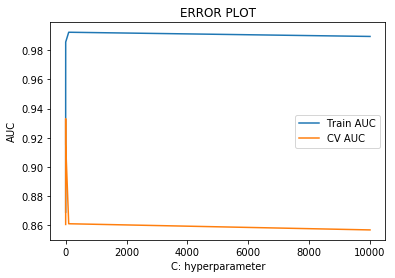

In [47]:
C =  [10**-4, 10**-2, 10**0, 10**2, 10**4]
train_auc= clf.cv_results_['mean_train_score']

cv_auc = clf.cv_results_['mean_test_score'] 

plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039

plt.plot(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOT")
plt.show()

In [45]:
print(clf.cv_results_)

{'mean_fit_time': array([ 0.62763691,  1.22722163,  9.17333908, 23.41683106, 23.58138666]), 'std_fit_time': array([0.17198519, 0.28599967, 0.31027187, 0.61997523, 0.75733605]), 'mean_score_time': array([0.02553325, 0.01775384, 0.02633052, 0.01815195, 0.02054696]), 'std_score_time': array([0.01716592, 0.00074686, 0.01528999, 0.00116443, 0.00623098]), 'param_C': masked_array(data=[0.0001, 0.01, 1, 100, 10000],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.0001}, {'C': 0.01}, {'C': 1}, {'C': 100}, {'C': 10000}], 'split0_test_score': array([0.87184787, 0.94258641, 0.92539021, 0.86583256, 0.8655627 ]), 'split1_test_score': array([0.85986097, 0.9296304 , 0.91375371, 0.86242933, 0.85252487]), 'split2_test_score': array([0.86109357, 0.93234949, 0.91443059, 0.86477753, 0.8603643 ]), 'split3_test_score': array([0.85710384, 0.93364207, 0.91282131, 0.85673411, 0.85667873]), 'split4_test_score': array([0.85359046, 0.92702

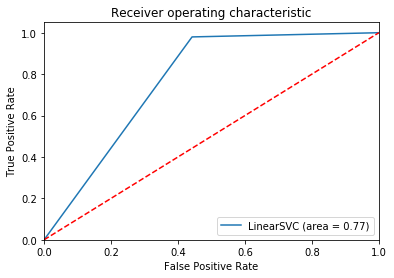

In [54]:
from sklearn.metrics import roc_auc_score
clf = LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

clf.fit(train_bow, train_scores)

logit_roc_auc = roc_auc_score(test_scores, clf.predict(test_bow))
fpr, tpr, thresholds = roc_curve(test_scores, clf.predict(test_bow)[:])
plt.figure()
plt.plot(fpr, tpr, label='LinearSVC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('LinearSVC_ROC')
plt.show()

             precision    recall  f1-score   support

          0       0.85      0.56      0.67      5199
          1       0.91      0.98      0.95     24801

avg / total       0.90      0.91      0.90     30000



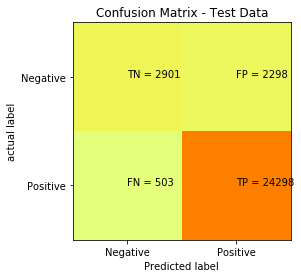

In [128]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
clf = LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
clf.fit(train_bow, train_scores)

pred = clf.predict(test_bow)
print(classification_report(test_scores, pred))
cnf = confusion_matrix(test_scores, pred)

plt.imshow(cnf, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=360)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cnf[i][j]))
plt.show()

#### [5.1.1.1] top 10 posirive and negitive points

In [88]:
clf = LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
clf.fit(train_bow,train_scores)
class_labels = clf.classes_
feature_names = count_vect.get_feature_names()
topn_class1 = sorted(zip(clf.coef_[0], feature_names))[:10]
topn_class2 = sorted(zip(clf.coef_[0], feature_names))[-10:]

print("top 10 negitive features:")
for coef, feat in topn_class1:
    print (class_labels[0], coef, feat)

top 10 negitive features:
0 -0.8977310891328556 worst
0 -0.8875856298395756 disappoint
0 -0.7232915242691514 aw
0 -0.6863558470645806 return
0 -0.6804326705071475 terribl
0 -0.6395636458909627 unfortun
0 -0.6127056153349706 horribl
0 -0.5970477745362791 stale
0 -0.5955235977134316 wast
0 -0.5928867245742225 threw


In [89]:
print("top 10 positive features:")
for coef, feat in reversed(topn_class2):
    print (class_labels[1], coef, feat)

top 10 positive features:
1 0.5361158300143226 delici
1 0.5057177532475463 perfect
1 0.4903207130825628 best
1 0.4807712321408994 excel
1 0.4711550557615308 awesom
1 0.4711125691014405 great
1 0.45810660665881636 worri
1 0.45754859489221866 amaz
1 0.41448447773882335 yummi
1 0.3636118668871025 happi


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [59]:
parameter = {'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}
 
clf = GridSearchCV(LinearSVC(loss='hinge'),parameter,scoring='roc_auc',cv=5,n_jobs=-1)

clf.fit(train_tfidf, train_scores)

print(clf.best_estimator_)
print('the best AUC score for tfidf:',clf.score(train_tfidf,train_scores))


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
the best AUC score for tfidf: 0.9691092561683059


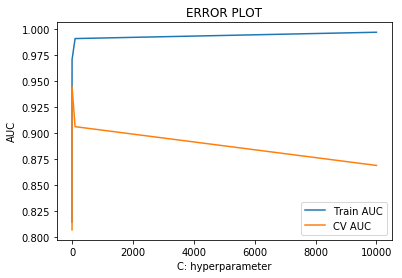

In [61]:
C =  [10**-4, 10**-2, 10**0, 10**2, 10**4]
train_auc= clf.cv_results_['mean_train_score']

cv_auc = clf.cv_results_['mean_test_score'] 

plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039

plt.plot(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOT")
plt.show()

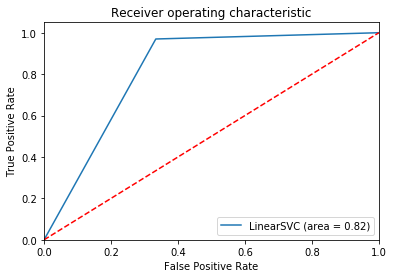

In [62]:
clf = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
clf.fit(train_tfidf, train_scores)

logit_roc_auc = roc_auc_score(test_scores, clf.predict(test_tfidf))
fpr, tpr, thresholds = roc_curve(test_scores, clf.predict(test_tfidf)[:])
plt.figure()
plt.plot(fpr, tpr, label='LinearSVC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('LinearSVC_ROC')
plt.show()

             precision    recall  f1-score   support

          0       0.82      0.67      0.74      5199
          1       0.93      0.97      0.95     24801

avg / total       0.91      0.92      0.91     30000



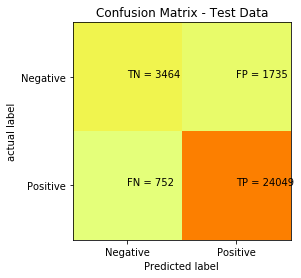

In [63]:
from sklearn.metrics import classification_report
clf = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
clf.fit(train_tfidf, train_scores)
pred = clf.predict(test_tfidf)
print(classification_report(test_scores, pred))
cnf = confusion_matrix(test_scores, pred)

plt.imshow(cnf, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=360)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cnf[i][j]))
plt.show()

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [64]:
# Please write all the code with proper documentation
parameter = {'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}

model = GridSearchCV(LinearSVC(loss='hinge'),parameter,scoring='roc_auc',cv=5,n_jobs=-1)

model.fit(avg_w2v_train, train_scores)

print(model.best_estimator_)
print(model.score(avg_w2v_train,train_scores))


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
0.9085530139072923


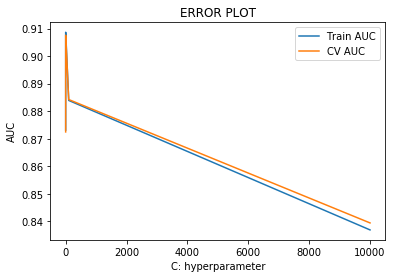

In [65]:
C =  [10**-4, 10**-2, 10**0, 10**2, 10**4]
train_auc= model.cv_results_['mean_train_score']

cv_auc = model.cv_results_['mean_test_score'] 

plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039

plt.plot(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOT")
plt.show()

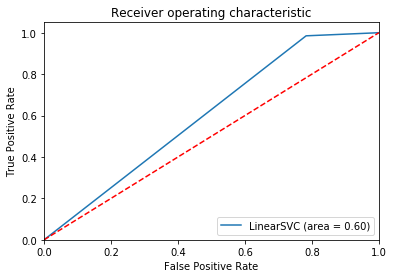

In [66]:
clf = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
clf.fit(avg_w2v_train, train_scores)

logit_roc_auc = roc_auc_score(test_scores, clf.predict(avg_w2v_test))
fpr, tpr, thresholds = roc_curve(test_scores, clf.predict(avg_w2v_test)[:])
plt.figure()
plt.plot(fpr, tpr, label='LinearSVC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('LinearSVC_ROC')
plt.show()

             precision    recall  f1-score   support

          0       0.79      0.21      0.33      5199
          1       0.86      0.99      0.92     24801

avg / total       0.84      0.85      0.82     30000



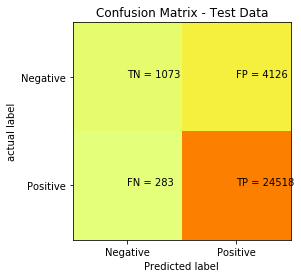

In [130]:
clf = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

clf.fit(avg_w2v_train, train_scores)
pred = clf.predict(avg_w2v_test)
print(classification_report(test_scores, pred))
cnf = confusion_matrix(test_scores, pred)

plt.imshow(cnf, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=360)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cnf[i][j]))
plt.show()

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [67]:
# Please write all the code with proper documentation
parameter = {'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}

model = GridSearchCV(LinearSVC(loss='hinge'),parameter,scoring='roc_auc',cv=5)

model.fit(tfidf_w2v_train, train_scores)

print(model.best_estimator_)
print(model.score(tfidf_w2v_train,train_scores))


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
0.8818138438458236


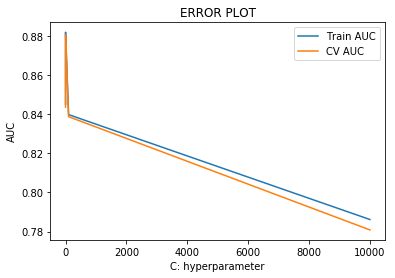

In [68]:
C =  [10**-4, 10**-2, 10**0, 10**2, 10**4]
train_auc= model.cv_results_['mean_train_score']

cv_auc = model.cv_results_['mean_test_score'] 

plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039

plt.plot(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOT")
plt.show()

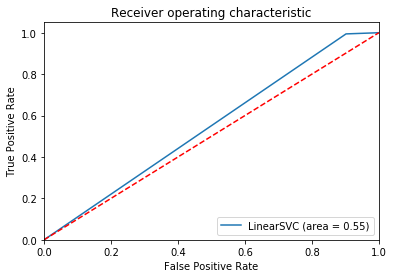

In [69]:
clf = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
clf.fit(tfidf_w2v_train, train_scores)

logit_roc_auc = roc_auc_score(test_scores, clf.predict(avg_w2v_test))
fpr, tpr, thresholds = roc_curve(test_scores, clf.predict(avg_w2v_test)[:])
plt.figure()
plt.plot(fpr, tpr, label='LinearSVC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('LinearSVC_ROC')
plt.show()

             precision    recall  f1-score   support

          0       0.75      0.13      0.23      5199
          1       0.85      0.99      0.91     24801

avg / total       0.83      0.84      0.79     30000



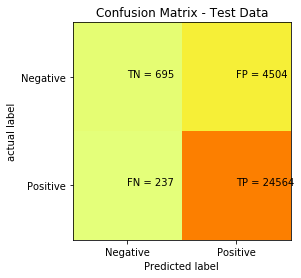

In [131]:
clf = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
clf.fit(tfidf_w2v_train, train_scores)
pred = clf.predict(tfidf_w2v_test)
print(classification_report(test_scores, pred))
cnf = confusion_matrix(test_scores, pred)

plt.imshow(cnf, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=360)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cnf[i][j]))
plt.show()

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [121]:
from sklearn.svm import SVC

In [70]:
# Please write all the code with proper documentation
clf = SVC(kernel='rbf')
param = {'gamma':[10**-4, 10**-2, 10**0, 10**2, 10**4],
             'C':[10**-4, 10**-2, 10**0, 10**2, 10**4]} #params we need to try on classifier
model = RandomizedSearchCV(clf,param,cv=5,scoring='roc_auc',n_jobs=-1)
model.fit(train_rbf_bow,train_rbf_scores)
print(model.best_estimator_)
print(model.score(train_rbf_bow,train_rbf_scores)*100)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
90.51522858813735


AUC score for rbf kernal using BoW: 50.0


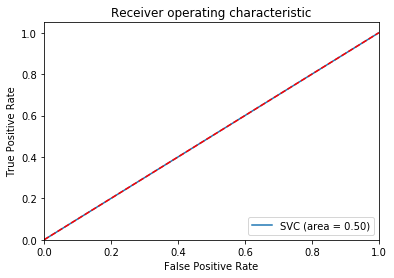

In [76]:
clf = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
      max_iter=-1, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

clf.fit(train_rbf_bow, train_rbf_scores)

logit_roc_auc = roc_auc_score(test_rbf_scores, clf.predict(test_rbf_bow))
print('AUC score for rbf kernal using BoW:',logit_roc_auc*100)
fpr, tpr, thresholds = roc_curve(test_rbf_scores, clf.predict(test_rbf_bow)[:])
plt.figure()
plt.plot(fpr, tpr, label='SVC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

             precision    recall  f1-score   support

          0       0.85      0.35      0.49      1237
          1       0.88      0.99      0.93      5763

avg / total       0.87      0.87      0.85      7000



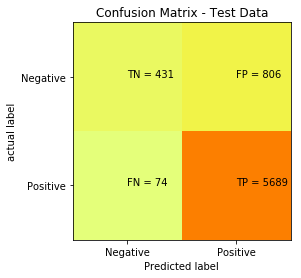

In [132]:
clf = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

clf.fit(train_rbf_bow, train_rbf_scores)
pred = clf.predict(test_rbf_bow)
print(classification_report(test_rbf_scores, pred))
cnf = confusion_matrix(test_rbf_scores, pred)

plt.imshow(cnf, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=360)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cnf[i][j]))
plt.show()

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [124]:
clf = SVC(kernel='rbf')
param = {'gamma':[10**-4, 10**-2, 10**0, 10**2, 10**4],
             'C':[10**-4, 10**-2, 10**0, 10**2, 10**4]} #params we need to try on classifier
model = RandomizedSearchCV(clf,param,cv=5,scoring='roc_auc',n_jobs=-1)
model.fit(train_rbf_tfidf,train_rbf_scores)
print(model.best_estimator_)
print(model.score(train_rbf_tfidf,train_rbf_scores)*100)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
100.0


AUC score for rbf kernel using tfidf: 77.08218350095748


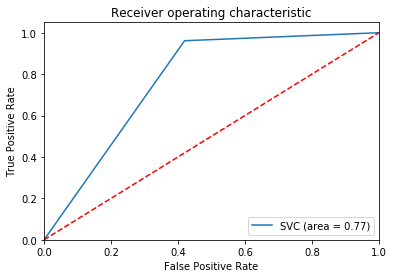

In [77]:
clf = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

clf.fit(train_rbf_tfidf, train_rbf_scores)

logit_roc_auc = roc_auc_score(test_rbf_scores, clf.predict(test_rbf_tfidf))
print('AUC score for rbf kernel using tfidf:',logit_roc_auc*100)
fpr, tpr, thresholds = roc_curve(test_rbf_scores, clf.predict(test_rbf_tfidf)[:])
plt.figure()
plt.plot(fpr, tpr, label='SVC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

             precision    recall  f1-score   support

          0       0.77      0.52      0.62      1237
          1       0.90      0.97      0.93      5763

avg / total       0.88      0.89      0.88      7000



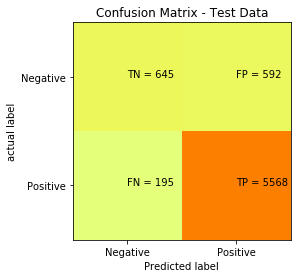

In [134]:
clf = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


clf.fit(train_rbf_tfidf , train_rbf_scores)
pred = clf.predict(test_rbf_tfidf)
print(classification_report(test_rbf_scores, pred))
cnf = confusion_matrix(test_rbf_scores, pred)

plt.imshow(cnf, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=360)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cnf[i][j]))
plt.show()

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [125]:
clf = SVC(kernel='rbf')
param = {'C': [10**-4, 10**-2, 10**0, 10**2, 10**4],'gamma':[10**-4, 10**-2, 10**0, 10**2, 10**4]}

model = RandomizedSearchCV(clf,param,scoring='roc_auc',cv=5,n_jobs=-1)

model.fit(avg_w2v_train_rbf, train_rbf_scores)

print(model.best_estimator_)
print(model.score(avg_w2v_train_rbf,train_rbf_scores))

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.8695789662612979


AUC score for rbf kernel using avg_w2v: 50.0


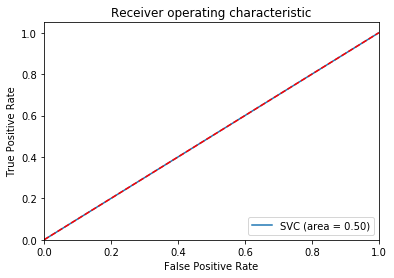

In [78]:
clf = SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

clf.fit(avg_w2v_train_rbf, train_rbf_scores)

logit_roc_auc = roc_auc_score(test_rbf_scores, clf.predict(avg_w2v_test_rbf))
print('AUC score for rbf kernel using avg_w2v:',logit_roc_auc*100)
fpr, tpr, thresholds = roc_curve(test_rbf_scores, clf.predict(avg_w2v_test_rbf)[:])
plt.figure()
plt.plot(fpr, tpr, label='SVC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1237
          1       0.82      1.00      0.90      5763

avg / total       0.68      0.82      0.74      7000



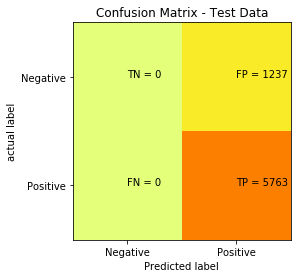

In [136]:
clf = SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


clf.fit(avg_w2v_train_rbf , train_rbf_scores)
pred = clf.predict(avg_w2v_test_rbf)
print(classification_report(test_rbf_scores, pred))
cnf = confusion_matrix(test_rbf_scores, pred)

plt.imshow(cnf, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=360)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cnf[i][j]))
plt.show()

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [126]:
clf = SVC(kernel='rbf')
param = {'C': [10**-4, 10**-2, 10**0, 10**2, 10**4],'gamma':[10**-4, 10**-2, 10**0, 10**2, 10**4]}

model = RandomizedSearchCV(clf,param,scoring='roc_auc',cv=5,n_jobs=-1)

model.fit(tfidf_w2v_train_rbf, train_rbf_scores)

print(model.best_estimator_)
print(model.score(tfidf_w2v_train_rbf,train_rbf_scores))


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.8670712544849283


AUC score for rbf kernel using tfidf_w2v: 50.10097111025207


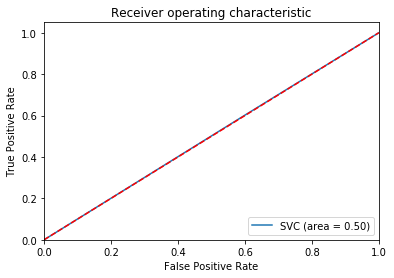

In [79]:
clf = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

clf.fit(tfidf_w2v_train_rbf , train_rbf_scores)
logit_roc_auc = roc_auc_score(test_rbf_scores, clf.predict(tfidf_w2v_test_rbf))
print('AUC score for rbf kernel using tfidf_w2v:',logit_roc_auc*100)
fpr, tpr, thresholds = roc_curve(test_rbf_scores, clf.predict(tfidf_w2v_test_rbf)[:])
plt.figure()
plt.plot(fpr, tpr, label='SVC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

             precision    recall  f1-score   support

          0       0.23      0.51      0.32      1237
          1       0.86      0.64      0.73      5763

avg / total       0.75      0.61      0.66      7000



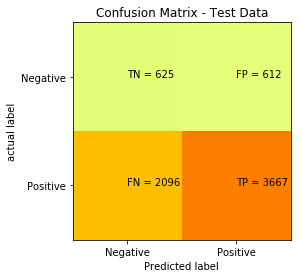

In [137]:
clf = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


clf.fit(tfidf_w2v_train_rbf , train_rbf_scores)
pred = clf.predict(tfidf_w2v_test_rbf)
print(classification_report(test_rbf_scores, pred))
cnf = confusion_matrix(test_rbf_scores, pred)

plt.imshow(cnf, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=360)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cnf[i][j]))
plt.show()

# [6] Conclusions

*************************************************************************************************************
*   kernel   |    featurization   |  hyperparameter  |  TPR  |  FPR  |  F1-score  |  precision  |   recall  *
*************************************************************************************************************
*            |         BoW        |      C=0.01      | 91.3% | 85.2% |    90%     |     90%     |     91%   *
*            |***********************************************************************************************
*            |        tfidf       |       C=1        | 93.2% | 82.1% |    91%     |     91%     |     92%   *
*   linear   |***********************************************************************************************
*            |       avg_w2v      |       C=1        | 85.5% | 79.1% |    82%     |     84%     |     85%   *
*            |***********************************************************************************************
*            |      tfidf_w2v     |       C=1        | 85.5% | 79.1% |    79%     |     83%     |     84%   *
*************************************************************************************************************
*            |         Bow        | C=1,gamma=0.0001 | 87.5% | 81.7% |    85%     |     87%     |     87%   *
*            |***********************************************************************************************
*            |        tfidf       |   C=100,gamma=1  | 90.3% | 76.7% |    88%     |     88%     |     89%   *
*    rbf     |***********************************************************************************************
*            |       avg_w2v      | C=0.01,gamma=0.01| 82.3% | 76.7% |    74%     |     68%     |     82%   *
*            |***********************************************************************************************
*            |      tfidf_w2v     | C=100,gamma=0.01 | 85.6% | 25.1% |    66%     |     75%     |     61%   *
*************************************************************************************************************
